In [119]:
from pandas.io.json import json_normalize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D

In [120]:
clusters = pd.read_json("./files/cluster.json")

ValueError: Expected object or value

In [121]:
def plotSteps(data):
    for runIdx in range(0, len(data)):
        fig, ax = plt.subplots()
        iteration = data.iloc[runIdx]["iteration"]
        clusters = data.iloc[runIdx]["clusters"]
        norm = colors.Normalize(vmin=0, vmax=len(clusters))
        print("iteration: %s, clusters: %s" % (iteration, len(clusters)))
        for cIdx in range(0, len(clusters)):
            rgba_color = cm.gnuplot(norm(cIdx))
            pointsX = [point[0] for point in clusters[cIdx]["points"]]
            pointsY = [point[1] for point in clusters[cIdx]["points"]]
            ax.scatter(pointsX, pointsY, color=rgba_color)
            ax.scatter(clusters[cIdx]["centroid"][0], clusters[cIdx]["centroid"][1], color=rgba_color, marker="+")

        plt.show()

In [122]:
plotSteps(clusters)

NameError: name 'clusters' is not defined

In [123]:
def plot(data):
    for runIdx in range(0, len(data)):
        fig, ax = plt.subplots()
        clusters_step1 = data.iloc[runIdx]["steps"][0]["clusters"]
        clusters_step2 = data.iloc[runIdx]["steps"][1]["clusters"]
        norm = colors.Normalize(vmin=0, vmax=len(clusters_step1))
        for cIdx in range(0, len(clusters_step1)):
            rgba_color = cm.gnuplot(norm(cIdx))
            ax.plot(clusters_step1[cIdx]["syntheticCenter"], "--", color=rgba_color, label="cluster %s" % cIdx)
            ax.plot(clusters_step2[cIdx]["syntheticCenter"], color=rgba_color, label="cluster %s - rescheduled" % cIdx)
            print(clusters_step2[cIdx]["metric"])
        ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)

        ax.set(xlabel='Hours', ylabel='Power (kW)',title='')
        plt.show()

In [124]:
def plot_aggm(summary, file_name=None): 
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. agg m"], "--", color=rgba_color, label="s1. agg m")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. agg m"], color=rgba_color, label="s2. agg m")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Aggregate PAR',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig
    
def plot_maxm(summary, file_name=None): 
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. max m"], "--", color=rgba_color, label="s1. max m")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. max m"], color=rgba_color, label="s2. max m")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Max. Aggregate PAR',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig
    
def plot_peak(summary, file_name=None):
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. peak"], "--", color=rgba_color, label="s1. peak")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. peak"], color=rgba_color, label="s2. peak")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Peak power (kW)',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig

# PAR Aggregate

In [125]:
summaryBatch_global = pd.read_json("./files/crossfold-energy/summaryBatch.json")
#summaryBatch_global = summaryBatch_global[["k","clusters","s1. agg m","s1. max m","s1. peak","s2. agg m","s2. max m","s2. peak","total m"]]
#batch_global = pd.read_json("./files/batch.json")

k = 6
sampleSizeMin = 0.5
sampleSizeMax = 1.0
nSteps = 1


def sampleSizeRange():
    return (x/10 for x in range(int(sampleSizeMin * 10), int((sampleSizeMax * 10) + 1)))

In [126]:
index_list = []
step_list = []

for i in range(0 , len(summaryBatch_global)):
    register = summaryBatch_global.iloc[i]
    
    crossfold = json_normalize(register["crossfold"])
    splits = crossfold["splits"].values[0]
    steps = summaryBatch_global.iloc[i]["step"]
    for j in range(0, splits):
        step = json_normalize(steps[j])
        for ki in range(1, k+1):
            index_list.append((float("{0:.2f}".format(crossfold["sampleSize"].values[0])), j, ki))
            step_list.append(step.iloc[ki-1])
        
    
json_normalize(summaryBatch_global.iloc[0]["crossfold"])
json_normalize(summaryBatch_global.iloc[0]["step"][0])

index = pd.MultiIndex.from_tuples(index_list, names=["sampleSize", "split", "k"])
summaryBatch_global_treated = pd.DataFrame(step_list, index=index)
summaryBatch_global_treated

clusters  k  s1. agg m  s1. max m  \
sampleSize split k                                                      
0.5        0     1                      [94]  1   1.380964   1.380964   
                 2                  [61, 33]  2   1.006433   1.406308   
                 3              [48, 25, 21]  3   1.029799   1.455055   
                 4           [50, 25, 16, 3]  4   1.026366   1.510295   
                 5       [34, 22, 7, 15, 16]  5   1.054037   1.576613   
                 6   [9, 13, 17, 14, 15, 26]  6   1.063832   1.652003   
           1     1                      [94]  1   1.349424   1.349424   
                 2                  [45, 49]  2   1.000669   1.392965   
                 3              [46, 32, 16]  3   1.022109   1.422968   
                 4          [15, 28, 22, 29]  4   1.025785   1.467293   
                 5      [19, 21, 13, 22, 19]  5   1.028052   1.549582   
                 6  [21, 15, 15, 13, 16, 14]  6   1.073124   1.604115   
           2     1                      [94]  1   1.444775   1.444775   
                 2                  [55, 39]  2   1.000722   1.445680   
                 3               [62, 25, 7]  3   1.004935   1.463640   
                 4          [16, 17, 27, 34]  4   1.013763   1.503749   
                 5      [23, 19, 17, 16, 19]  5   1.031446   1.572289   
                 6  [14, 12, 12, 17, 17, 22]  6   1.031890   1.566482   
           3     1                      [94]  1   1.408298   1.408298   
                 2                   [85, 9]  2   1.000626   1.448385   
                 3              [17, 30, 47]  3   1.006718   1.557264   
                 4          [40, 17, 23, 14]  4   1.038093   1.589928   
                 5      [10, 17, 20, 22, 25]  5   1.052555   1.674794   
                 6   [20, 21, 17, 13, 18, 5]  6   1.039108   1.706279   
           4     1                      [94]  1   1.494860   1.494860   
                 2                  [75, 19]  2   1.001897   1.504234   
                 3              [18, 33, 43]  3   1.012180   1.525343   
                 4          [24, 21, 18, 31]  4   1.024973   1.583141   
                 5      [16, 18, 23, 19, 18]  5   1.054718   1.657009   
                 6    [27, 23, 21, 6, 7, 10]  6   1.083490   1.673724   
...                                      ... ..        ...        ...   
1.0        89    1                     [189]  1   1.371114   1.371114   
                 2                 [84, 105]  2   1.001772   1.373963   
                 3              [65, 63, 61]  3   1.002481   1.375946   
                 4          [29, 58, 48, 54]  4   1.014650   1.431363   
                 5      [18, 33, 37, 49, 52]  5   1.032385   1.464280   
                 6  [15, 27, 26, 29, 47, 45]  6   1.036045   1.478525   
           90    1                     [189]  1   1.371114   1.371114   
                 2                 [151, 38]  2   1.000347   1.371873   
                 3              [65, 64, 60]  3   1.012614   1.401092   
                 4          [70, 47, 35, 37]  4   1.013767   1.431677   
                 5      [62, 32, 34, 36, 25]  5   1.035576   1.499624   
                 6  [41, 35, 30, 29, 31, 23]  6   1.052268   1.477405   
           91    1                     [189]  1   1.371114   1.371114   
                 2                  [90, 99]  2   1.000160   1.371317   
                 3              [83, 57, 49]  3   1.020634   1.397180   
                 4          [46, 46, 41, 56]  4   1.005193   1.464309   
                 5      [27, 30, 46, 37, 49]  5   1.030835   1.463367   
                 6  [55, 47, 29, 22, 21, 15]  6   1.035054   1.514186   
           92    1                     [189]  1   1.371114   1.371114   
                 2                 [84, 105]  2   1.002030   1.374613   
                 3              [66, 51, 72]  3   1.005602   1.382649   
                 4          [69, 59, 33, 28]  4   1.008532   1.393430   
                 5   

In [127]:
k2 = 2
query = f"k == {k2} and sampleSize == {sampleSizeMin}"
summaryBatch_global_treated.query(query)["s1. agg m"].mean()
summaryBatch_global_treated.query(query)["s1. max m"].mean()
summaryBatch_global_treated.query(query)["s1. peak"].std()

43.932734321233703

In [128]:
with open('summaryBatch.tex','w') as tf:
    tf.write(summaryBatch_global.to_latex())

In [129]:
index_list = []
step_list = []

for j in range(1, k+1):
    for ssize in sampleSizeRange():
        
        index_list.append((ssize, "mean", j))
        query = f"k == {j} and sampleSize == {ssize}"
        data = {"s1. agg m" : summaryBatch_global_treated.query(query)["s1. agg m"].mean(),
                "s1. max m" : summaryBatch_global_treated.query(query)["s1. max m"].mean(), 
                "s1. peak" : summaryBatch_global_treated.query(query)["s1. peak"].mean()}
        index = ["s1. agg m","s1. max m","s1. peak"]
        if (nSteps >= 2):
            data.update({"s2. agg m" : summaryBatch_global_treated.query(query)["s2. agg m"].mean(),
                "s2. max m" : summaryBatch_global_treated.query(query)["s2. max m"].mean(), 
                "s2. peak" : summaryBatch_global_treated.query(query)["s2. peak"].mean()})
            index = index + ["s2. agg m","s2. max m","s2. peak"]
            
        s = pd.Series(data,index=index) 
        step_list.append(s)
        #print(f"sampleSize = {ssize}, k = {j}")
        
        index_list.append((ssize, "stdv", j))
        query = f"k == {j} and sampleSize == {ssize}"
        data = {"s1. agg m" : summaryBatch_global_treated.query(query)["s1. agg m"].std(),
                "s1. max m" : summaryBatch_global_treated.query(query)["s1. max m"].std(), 
                "s1. peak" : summaryBatch_global_treated.query(query)["s1. peak"].std()}
        index = ["s1. agg m","s1. max m","s1. peak"]
        if (nSteps >= 2):
            data.update({"s2. agg m" : summaryBatch_global_treated.query(query)["s2. agg m"].std(),
                "s2. max m" : summaryBatch_global_treated.query(query)["s2. max m"].std(), 
                "s2. peak" : summaryBatch_global_treated.query(query)["s2. peak"].std()})
            index = index + ["s2. agg m","s2. max m","s2. peak"]
            
        s = pd.Series(data,index=index) 
        step_list.append(s)

        
index = pd.MultiIndex.from_tuples(index_list, names=["sampleSize", "metric", "k"])
summaryBatch_global_statistics = pd.DataFrame(step_list, index=index)
summaryBatch_global_statistics

s1. agg m     s1. max m      s1. peak
sampleSize metric k                                          
0.5        mean   1  1.396462e+00  1.396462e+00  3.389216e+02
           stdv   1  5.761131e-02  5.761131e-02  3.063024e+01
0.6        mean   1  1.389820e+00  1.389820e+00  4.063849e+02
           stdv   1  4.602560e-02  4.602560e-02  2.796268e+01
0.7        mean   1  1.388840e+00  1.388840e+00  4.798856e+02
           stdv   1  3.300573e-02  3.300573e-02  2.314771e+01
0.8        mean   1  1.376067e+00  1.376067e+00  5.450925e+02
           stdv   1  2.583805e-02  2.583805e-02  2.138964e+01
0.9        mean   1  1.373582e+00  1.373582e+00  6.080162e+02
           stdv   1  2.025208e-02  2.025208e-02  1.563500e+01
1.0        mean   1  1.371114e+00  1.371114e+00  6.761602e+02
           stdv   1  2.232352e-16  2.232352e-16  2.285928e-13
0.5        mean   2  1.001791e+00  1.410522e+00  2.057012e+02
           stdv   2  2.107944e-03  5.575444e-02  4.393273e+01
0.6        mean   2  1.001664e+00  1.401983e+00  2.385208e+02
           stdv   2  1.647545e-03  4.365502e-02  4.279950e+01
0.7        mean   2  1.001041e+00  1.398542e+00  2.874405e+02
           stdv   2  1.025189e-03  3.053365e-02  5.128261e+01
0.8        mean   2  1.001211e+00  1.384020e+00  3.193913e+02
           stdv   2  1.339798e-03  2.593227e-02  6.481901e+01
0.9        mean   2  1.000871e+00  1.379137e+00  3.544219e+02
           stdv   2  8.196725e-04  1.800988e-02  6.234225e+01
1.0        mean   2  1.000665e+00  1.374143e+00  4.089155e+02
           stdv   2  6.723664e-04  6.087891e-03  7.997255e+01
0.5        mean   3  1.012565e+00  1.461277e+00  1.579599e+02
           stdv   3  7.780708e-03  5.717481e-02  4.074505e+01
0.6        mean   3  1.010031e+00  1.437089e+00  1.824817e+02
           stdv   3  6.446441e-03  4.624419e-02  4.256733e+01
0.7        mean   3  1.009025e+00  1.430216e+00  2.184232e+02
           stdv   3  6.055629e-03  3.756212e-02  5.354699e+01
...                           ...           ...           ...
0.8        mean   4  1.018291e+00  1.457956e+00  1.925888e+02
           stdv   4  1.204215e-02  3.162544e-02  4.837722e+01
0.9        mean   4  1.016716e+00  1.445763e+00  2.090993e+02
           stdv   4  7.614950e-03  2.900382e-02  4.884046e+01
1.0        mean   4  1.015163e+00  1.429992e+00  2.261771e+02
           stdv   4  6.522515e-03  1.987244e-02  5.242627e+01
0.5        mean   5  1.038560e+00  1.554961e+00  1.109003e+02
           stdv   5  1.484916e-02  6.339969e-02  3.449614e+01
0.6        mean   5  1.032469e+00  1.523818e+00  1.245644e+02
           stdv   5  1.194685e-02  5.678978e-02  2.851431e+01
0.7        mean   5  1.030512e+00  1.514464e+00  1.391729e+02
           stdv   5  1.173710e-02  4.516206e-02  3.549710e+01
0.8        mean   5  1.030106e+00  1.495744e+00  1.581899e+02
           stdv   5  1.172317e-02  3.350077e-02  3.692494e+01
0.9        mean   5  1.028222e+00  1.481513e+00  1.791482e+02
           stdv   5  9.528180e-03  2.761533e-02  4.250454e+01
1.0        mean   5  1.026647e+00  1.462162e+00  2.013125e+02
           stdv   5  9.796525e-03  1.927030e-02  4.714731e+01
0.5        mean   6  1.050917e+00  1.600016e+00  9.968572e+01
           stdv   6  1.896067e-02  6.640669e-02  2.780204e+01
0.6        mean   6  1.041259e+00  1.563909e+00  1.126686e+02
           stdv   6  1.611328e-02  6.194204e-02  3.392324e+01
0.7        mean   6  1.043849e+00  1.555815e+00  1.345359e+02
           stdv   6  1.571706e-02  4.415654e-02  3.885801e+01
0.8        mean   6  1.042759e+00  1.524596e+00  1.500106e+02
           stdv   6  1.139831e-02  3.554444e-02  3.525467e+01
0.9        mean   6  1.036633e+00  1.507750e+00  1.664693e+02
           stdv   6  1.070580e-02  3.097481e-02  3.411264e+01
1.0        mean   6  1.034796e+00  1.492908e+00  1.736638e+02
           stdv   6  8.233557e-03  2.092269e-02  3.365254e+01

[72 rows x 3 columns]

In [130]:
def getMetrics(metric, summaryMetric):

    index_list = [sampleSizeRange()]
    cols = [x for x in range(1, k+1)]
    step_list = []

    for ssize in sampleSizeRange():
        query = f"sampleSize == {ssize} and metric == \"{summaryMetric}\" "
        dataAllK = summaryBatch_global_statistics.query(query)[f"{metric}"]
        dictAllK = {}
        for j in range(1, k+1):
            d = dataAllK.reset_index().query(f"k == {j}")[f"{metric}"]
            dictAllK[f"{j}"] = d.values[0]
        s = pd.Series(dictAllK, name=f"{ssize}")
        step_list.append(s)

    return pd.DataFrame(step_list)
    
m = getMetrics("s1. peak", "mean")

In [131]:
m

,1,2,3,4,5,6
0.5,338.921633,205.701188,157.959851,124.541860,110.900347,99.685715
0.6,406.384869,238.520819,182.481693,142.773465,124.564418,112.668609
0.7,479.885582,287.440501,218.423244,167.882157,139.172928,134.535941
0.8,545.092514,319.391343,245.263340,192.588834,158.189915,150.010620
0.9,608.016184,354.421874,261.649397,209.099341,179.148189,166.469284
1.0,676.160150,408.915451,277.239788,226.177060,201.312466,173.663762


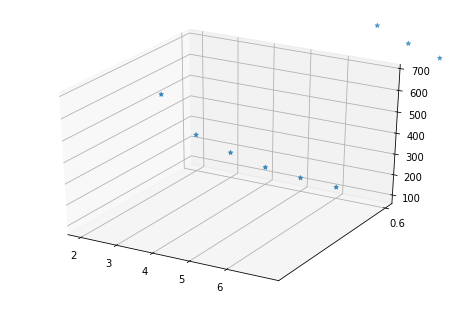

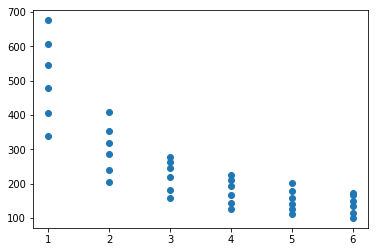

In [132]:
x_list = []
y_list = []
z_list = []
for i in m.index.values:
    for c in m.columns.values:
        x_list.append(i)
        y_list.append(c)
        z_list.append(m.loc[i:i, c:c].values[0][0])
        
fig = plt.figure()
ax = Axes3D(fig)


ax.scatter(y_list, x_list, z_list, marker='*')
plt.show()

plt.scatter(y_list, z_list)

In [133]:
a = summaryBatch_global_statistics.query("sampleSize == 1.0 and metric == \"mean\"").reset_index().drop(["sampleSize", "metric"], axis=1)

In [140]:
_list = {}
for j in range(1, k+1):
    _list[j - 1] = str(summaryBatch_global_treated.query(f"sampleSize == 1.0 and k == {j}").sort_values(by=["s1. max m", "s1. agg m"]).iloc[0]["clusters"])
_list
b = pd.DataFrame.from_dict(_list, orient="index", columns=["clusters"])
r = pd.concat([a,b], axis=1, sort=False)
r = r[["k", "clusters", "s1. agg m", "s1. max m", "s1. peak"]]
r

,k,clusters,s1. agg m,s1. max m,s1. peak
0,1,[189],1.371114,1.371114,676.160150
1,2,"[111, 78]",1.000665,1.374143,408.915451
2,3,"[90, 60, 39]",1.006628,1.397967,277.239788
3,4,"[35, 51, 51, 52]",1.015163,1.429992,226.177060
4,5,"[81, 53, 33, 17, 5]",1.026647,1.462162,201.312466
5,6,"[27, 23, 21, 24, 35, 59]",1.034796,1.492908,173.663762


In [141]:
getMetrics("s1. agg m", "mean").iloc[-1]

1    1.371114
2    1.000665
3    1.006628
4    1.015163
5    1.026647
6    1.034796
Name: 1.0, dtype: float64

In [142]:
with open('summaryBatch.tex','w') as tf:
    tf.write(r.to_latex())